# Part 1: Training a Single-Step Denoising UNet

## Setup environment

In [ ]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch

from PIL import Image
import mediapy as media
from pprint import pprint
from tqdm import tqdm
import os
import copy

In [ ]:
mnist_test = MNIST(root="data", train=False, download=True, transform=ToTensor())
mnist_train = MNIST(root="data", train=True, download=True, transform=ToTensor())

In [ ]:
def media_image(im):
    try:
        return im.permute(1,2,0) / 2. + 0.5
    except:

        return im.transpose(1,2,0)

In [ ]:
# generate z from x using the following noise process
# z = x + sigma * epsilon
# where eps ~ N(0,I)
def generate_z(x: torch.Tensor, sigma: float) -> torch.Tensor:
  return x + sigma * torch.randn_like(x)

## 1.1 UNet Architecture

### 1.1.0 Implementing Simple and Composed Ops

In [ ]:
class Conv(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
       self.bn = nn.BatchNorm2d(out_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class DownConv(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
       self.bn = nn.BatchNorm2d(out_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class UpConv(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
       self.bn = nn.BatchNorm2d(out_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class Flatten(nn.Module):
   def __init__(self):
       super().__init__()
       self.pool = nn.AvgPool2d(7)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.pool(x))

class Unflatten(nn.Module):
   def __init__(self, in_channels: int):
       super().__init__()
       self.conv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0)
       self.bn = nn.BatchNorm2d(in_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class ConvBlock(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv1 = Conv(in_channels, out_channels)
       self.conv2 = Conv(out_channels, out_channels)

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.conv2(self.conv1(x))

class DownBlock(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv_block = ConvBlock(in_channels, out_channels)
       self.down = DownConv(out_channels, out_channels)

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.down(self.conv_block(x))

class UpBlock(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv_block = ConvBlock(in_channels, out_channels)
       self.up = UpConv(out_channels, out_channels)

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.up(self.conv_block(x))

### 1.1.1 Implementing the UNet

It is unconditional (no class conditioning). 

In [ ]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int, # this is D in the diagram
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_hiddens = num_hiddens

        # operational layers
        self.opr1 = ConvBlock(self.in_channels, self.num_hiddens)
        self.opr2 = DownBlock(self.num_hiddens, self.num_hiddens)
        self.opr3 = DownBlock(self.num_hiddens, self.num_hiddens * 2)
        self.opr4 = Flatten()
        self.opr5 = Unflatten(self.num_hiddens * 2)
        self.opr6 = UpBlock(self.num_hiddens * 4, self.num_hiddens)
        self.opr7 = UpBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr8 = ConvBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr9 = nn.Conv2d(self.num_hiddens, self.in_channels, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

       # Encoder
        x1 = self.opr1(x)
        x2 = self.opr2(x1)
        x3 = self.opr3(x2)
        x4 = self.opr4(x3)

        # Decoder
        x5 = self.opr5(x4)
        x6 = self.opr6(torch.cat([x3, x5], dim=1))
        x7 = self.opr7(torch.cat([x2, x6], dim=1))
        x8 = self.opr8(torch.cat([x1, x7], dim=1))
        x9 = self.opr9(x8)
        return x9

## 1.2 Using the UNet to Train a Denoiser

### 1.2.0. DELIVERABLE: A visualization of the noising process using σ = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]. (figure 3)

Visualizing Different Noising Processes Over MNIST

In [ ]:
sigmas = [0.0,0.2,0.4,0.5,0.6,0.8,1.0]
img_dict = {}
for j in range(5):
  for i in range(len(sigmas)):
    x = mnist_test[j][0]
    z = generate_z(x, sigmas[i])
    img_dict[f"σ = {sigmas[i]}"] = media_image(z)
  media.show_images(img_dict)

σ = 0.0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1.0


σ = 0.0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1.0


σ = 0.0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1.0


σ = 0.0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1.0


σ = 0.0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1.0


### 1.2.1 Training

Now, we will train the model to perform denoising.

- Objective: Train a denoiser to denoise noisy image `z` with `sigma=0.5` applied to a clean image.
- Dataset and dataloader: Use the MNIST dataset via torchvision.datasets.MNIST with flags to access training and test sets. Train only on the training set. Shuffle the dataset before creating the dataloader. Recommended batch size: 256. We'll train over our dataset for 5 epochs.
- You should only noise the image batches when fetched from the dataloader so that in every epoch the network will see new noised images, improving generalization.
- Model: Use the UNet architecture defined in section 1.1 with recommended hidden dimension D = 128.
- Optimizer: Use Adam optimizer with learning rate of 1e-4.

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'mps'

In [ ]:
def preview_model(model, sigmas=[0.5], n_sample=3):
  for i in range(n_sample):
    img_dict = {}
    x = mnist_test[i][0].to(device)
    img_dict['input \t |'] = media_image(x).cpu()
    for sigma in sigmas:
      z = generate_z(x, sigma).to(device)
      img_dict[f'Noisy (σ = {sigma}) \t |'] = media_image(z).cpu()
      result = model(z.unsqueeze(0))[0].cpu()
      img_dict["Output"] = media_image(result).detach()
    media.show_images(img_dict)
    print("\n")

In [ ]:
def plot_loss_curve(losses, logscale=True):
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Losses')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    if logscale:
        plt.yscale('log')  # Use log scale like in the example
    plt.grid(True)
    plt.show()

In [ ]:
def plot_loss_curve_scatter(losses):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(losses)), losses, s=1)
    plt.title('Training Losses')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.yscale('log')  # Use log scale like in the example
    plt.grid(True)
    plt.show()

In [ ]:
def train(sigma=0.5, training_set_non_loaded=None, preview=True, num_epochs=5, using_pure_noise_as_input=False):
  # shuffle training set and create data loader
  batch_size = 256
  training_set = torch.utils.data.DataLoader(training_set_non_loaded, batch_size=batch_size, shuffle=True)

  # model and hyperparameters
  print("device: ", device)
  num_hiddens = 128
  learning_rate = 1e-4
  model = UnconditionalUNet(in_channels=1, num_hiddens=num_hiddens)
  model.train()
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  loss_fn = nn.functional.mse_loss
  model_epoch1, model_epoch5 = None, None 

  # training loop
  losses = []
  for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    for batch_idx, (clean_images, _) in enumerate(training_set):
      clean_images = clean_images.to(device)
      z = generate_z(clean_images, sigma).to(device)
      optimizer.zero_grad()

      if using_pure_noise_as_input:
        z = torch.randn_like(clean_images).to(device)
        
      # forward pass and compute loss -- denoise the image using the model and compare
      denoised_prediction = model(z)
      loss = loss_fn(denoised_prediction, clean_images)

      # backward pass, optimize, track loss
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      losses.append(loss.item())
    
    # visualize results for first 3 data points for 1rst and 5th epoch
    # alternatively save it
    if epoch == 0: model_epoch1 = copy.deepcopy(model)
    if epoch == 4: model_epoch5 = copy.deepcopy(model) 

    # Save checkpoint
    epoch_loss = total_loss / len(training_set)
    # print(f'Epoch {epoch + 1} complete. Average loss: {epoch_loss:.6f}')
    checkpoint_path = f'unet_checkpoint_epoch{epoch}.pt'
    
    try: save_checkpoint(model, optimizer, epoch, epoch_loss, checkpoint_path)
    except: pass 

  try: 
    if preview: 
      preview_model(model_epoch1)
      preview_model(model_epoch5)
      plot_loss_curve(losses)
  except: print("Error plotting loss curve or previewing model")
  
  model.eval(), model_epoch1.eval()
  return model, losses, model_epoch1, model_epoch5

### 1.2.1 Training Deliverables 

- A training loss curve plot every few iterations during the whole training process (figure 4).
- Sample results on the test set after the first and the 5-th epoch (staff solution takes ~3 minutes for 5 epochs on a Colab T4 GPU). (figure 5, 6)

The first image is for epoch 1, the second is for epoch 5.

The loss curve is the next output

device:  mps


100%|██████████| 5/5 [15:45<00:00, 189.05s/it]


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output


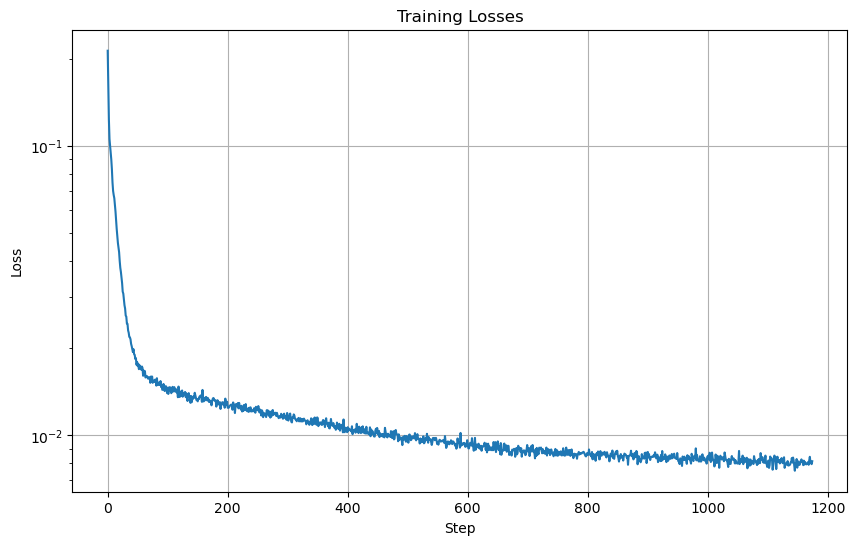

In [ ]:
single_step_denoiser, single_step_denoiser_losses, single_step_denoiser_epoch1, single_step_denoiser_epoch5 = train(sigma=0.5, training_set_non_loaded=mnist_train)

### 1.2.2 DELIVERABLE: Sample results on the test set with out-of-distribution noise levels after the model is trained. Keep the same image and vary σ = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]. (figure 7)

Out-of-Distribution Testing

In [ ]:
sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
x = mnist_test[0][0].to(device)

img_dict_1 = {}
img_dict_2 = {}
for sigma in sigmas:
  z = generate_z(x, sigma).to(device)
  img_dict_1[f'Noisy (σ = {sigma}) \t |'] = media_image(z).cpu()
  result = single_step_denoiser(z.unsqueeze(0))[0].cpu()
  img_dict_2[f"Output (σ = {sigma}) \t |"] = media_image(result).detach()
media.show_images(img_dict_1)
media.show_images(img_dict_2)

Noisy (σ = 0.0) |,Noisy (σ = 0.2) |,Noisy (σ = 0.4) |,Noisy (σ = 0.5) |,Noisy (σ = 0.6) |,Noisy (σ = 0.8) |,Noisy (σ = 1.0) |


Output (σ = 0.0) |,Output (σ = 0.2) |,Output (σ = 0.4) |,Output (σ = 0.5) |,Output (σ = 0.6) |,Output (σ = 0.8) |,Output (σ = 1.0) |


### 1.2.3 Denoising Pure Noise
### DELIVERABLE: Sample results on the test set with pure noise ε ~ N(0, I).

start with pure noise ϵ∼N(0,I) and denoise it for 5 epochs. Display your results after 1 and 5 epochs.



device:  mps


100%|██████████| 5/5 [13:08<00:00, 157.73s/it]


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output


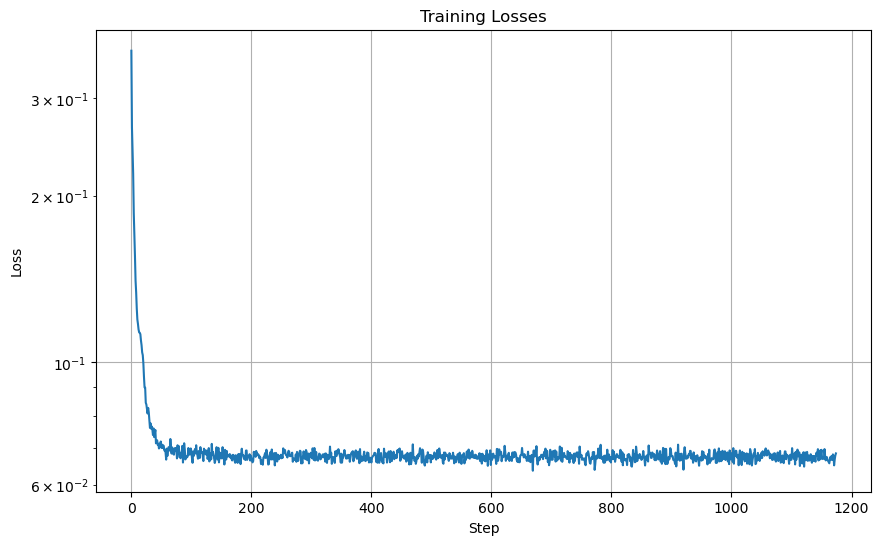

In [ ]:
pure_noise_denoiser, pure_noise_denoiser_losses, pure_noise_denoiser_epoch1, pure_noise_denoiser_epoch5 = train(sigma=0.5, training_set_non_loaded=mnist_train, using_pure_noise_as_input=True)

In [ ]:
def denoise_pure_noise(model_epoch1, model_epoch5, N=5):
    x = mnist_test[0][0]
    for _ in range(N):
        noise = torch.randn_like(x).to(device)
        epoch1_denoised = model_epoch1(noise.unsqueeze(0))[0].cpu()
        epoch5_denoised = model_epoch5(noise.unsqueeze(0))[0].cpu()
        img_dict = {}
        img_dict['Noise | '] = media_image(noise.cpu()).detach().numpy()
        img_dict['Epoch 1 | '] = media_image(epoch1_denoised.cpu()).detach().numpy()
        img_dict['Epoch 5 | '] = media_image(epoch5_denoised.cpu()).detach().numpy()
        media.show_images(img_dict)

denoise_pure_noise(pure_noise_denoiser_epoch1, pure_noise_denoiser_epoch5)

Noise |,Epoch 1 |,Epoch 5 |


Noise |,Epoch 1 |,Epoch 5 |


Noise |,Epoch 1 |,Epoch 5 |


Noise |,Epoch 1 |,Epoch 5 |


Noise |,Epoch 1 |,Epoch 5 |


### DELIVERABLE: Average image of the training set along with a brief description comparing it to the denoising results.


compute the average image of the training set. What do you notice between the average image and our attempts to denoise pure noise? Why might this be happening?

They look exactly the same. This is because what we are doing is basically to create structure from randomness. The average image is the most common pixel value at each pixel location across the training set, and since we are denoising pure noise, the model learns to create an image that resembles the average of the training set when minimizing the loss.

In [ ]:
# Compute the average image of the training set
def compute_average_image(dataset):
    total_image = torch.zeros_like(dataset[0][0])
    for image, _ in dataset:
        total_image += image
    average_image = total_image / len(dataset)
    return average_image

average_image = compute_average_image(mnist_train)
media.show_image(media_image(average_image))

""


# Part 2: Training a Flow Matching Model

In [ ]:
def lerp(x0, x1, t):
    t = t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(x0.device)
    return (1 - t) * x0 + t * x1

## 2.1 Adding Time Conditioning to UNet


UNet Architecture

### 2.1.0 Implementing Simple and Composed Ops

In [ ]:
class Conv(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
       self.bn = nn.BatchNorm2d(out_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class DownConv(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
       self.bn = nn.BatchNorm2d(out_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class UpConv(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
       self.bn = nn.BatchNorm2d(out_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class Flatten(nn.Module):
   def __init__(self):
       super().__init__()
       self.pool = nn.AvgPool2d(7)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.pool(x))

class Unflatten(nn.Module):
   def __init__(self, in_channels: int):
       super().__init__()
       self.conv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0)
       self.bn = nn.BatchNorm2d(in_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class ConvBlock(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv1 = Conv(in_channels, out_channels)
       self.conv2 = Conv(out_channels, out_channels)

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.conv2(self.conv1(x))

class DownBlock(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv_block = ConvBlock(in_channels, out_channels)
       self.down = DownConv(out_channels, out_channels)

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.down(self.conv_block(x))

class UpBlock(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv_block = ConvBlock(in_channels, out_channels)
       self.up = UpConv(out_channels, out_channels)

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.up(self.conv_block(x))

### 2.1.1 Implementing Time Conditioning

In [ ]:
# fully connected block, which injects time conditioning signal
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear2(self.gelu(self.linear(x.to(device))))

In [ ]:
class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_hiddens = num_hiddens

        # operational layers
        self.opr1 = ConvBlock(self.in_channels, self.num_hiddens)
        self.opr2 = DownBlock(self.num_hiddens, self.num_hiddens)
        self.opr3 = DownBlock(self.num_hiddens, self.num_hiddens * 2)
        self.opr4 = Flatten()
        self.opr5 = Unflatten(self.num_hiddens * 2)
        self.opr6 = UpBlock(self.num_hiddens * 4, self.num_hiddens)
        self.opr7 = UpBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr8 = ConvBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr9 = nn.Conv2d(self.num_hiddens, self.in_channels, kernel_size=3, stride=1, padding=1)

        self.fc1 = FCBlock(1, self.num_hiddens * 2)
        self.fc2 = FCBlock(1, self.num_hiddens)

    # make t in the right shape (N, 2D, 1, 1)
    # dimensions are tricky here: [N] -> [N, 1] --fc--> [N, 2D] --> [N, 2D, 1, 1] --> [N, 2D, 7, 7]
    # or the second one to [N,D,14,14]
    def apply_fc_block(self, obj, fc_block):
        obj = obj.unsqueeze(-1) # [N] -> [N, 1]
        obj = fc_block(obj) # [N, 1] -> [N, 2D]
        obj = obj.unsqueeze(-1).unsqueeze(-1) # [N, 2D] -> [N, 2D, 1, 1]
        return obj

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        # Encoder
        x1 = self.opr1(x)
        x2 = self.opr2(x1)
        x3 = self.opr3(x2)
        x4 = self.opr4(x3)

        # Decoder
        x_ = self.opr5(x4)
        t1 = self.apply_fc_block(t, self.fc1)
        x5 = x_ + t1

        x_ = self.opr6(torch.cat([x3, x5], dim=1))
        t2 = self.apply_fc_block(t, self.fc2)
        x6 = x_ + t2

        x7 = self.opr7(torch.cat([x2, x6], dim=1))
        x8 = self.opr8(torch.cat([x1, x7], dim=1))
        x9 = self.opr9(x8)
        return x9

## 2.2 Training the UNet

### Visualization Functions

In [ ]:
def preview_model(model, sigmas=[0.5], n_sample=3):
  for i in range(n_sample):
    img_dict = {}
    x = mnist_test[i][0].to(device)
    img_dict['input \t |'] = media_image(x).cpu()
    for sigma in sigmas:
      z = generate_z(x, sigma).to(device)
      img_dict[f'Noisy (σ = {sigma}) \t |'] = media_image(z).cpu()
      result = model(z.unsqueeze(0))[0].cpu()
      img_dict["Output"] = media_image(result).detach()
    media.show_images(img_dict)
    print("\n")

In [ ]:
def plot_loss_curve(losses, logscale=True):
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Losses')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    if logscale:
        plt.yscale('log')  # Use log scale like in the example
    plt.grid(True)
    plt.show()

### Flow Matching Model

In [ ]:
def fm_forward(
    unet: TimeConditionalUNet,
    x_1: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1

    Args:
        unet: TimeConditionalUNet
        x_1: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) loss.
    """
    unet.train()
    
    # we sample a random t because we don't want the model to overfit based on sequential patterns, but also want it to learn the relationship between t and the noise prediction
    t = torch.randint(0, num_ts, (x_1.shape[0],))
    t_normalized = t / num_ts  # normalize t to [0, 1]
    
    # get x_t
    x_0 = torch.randn_like(x_1)  # random noise
    x_t = lerp(x_0, x_1, t_normalized)  # linear interpolation between x_0 and x_1
    flow = x_1 - x_0
    
    # predict flow via unet 
    predicted_flow = unet(x_t, t_normalized)
    
    # calculate loss
    loss = torch.nn.functional.mse_loss(predicted_flow, flow)  
    return loss
    

In [ ]:
@torch.inference_mode()
def fm_sample(
    unet: TimeConditionalUNet,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2

    Args:
        unet: TimeConditionalUNet
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    torch.manual_seed(seed)
    x_t = torch.randn(1, 1, img_wh[0], img_wh[1]).to(device)
    for t in np.linspace(0, 1, num_ts, endpoint=False): 
        t_normalized = torch.Tensor([t]) 
        predicted_flow = unet(x_t, t_normalized)
        
        # calculate x_t
        x_t = x_t + (1.0/num_ts) * predicted_flow
    return x_t

In [ ]:
class FlowMatching(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        num_ts: int = 50,
        img_hw: tuple[int, int] = (28, 28),
    ):
        super().__init__()

        self.unet = unet
        self.num_ts = num_ts
        self.img_hw = img_hw


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return fm_forward(
            self.unet, x, self.num_ts
        )


    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return fm_sample(
            self.unet, img_wh, self.num_ts, seed
        )


### TRAINING

In [ ]:
def train_flow_matching(training_set_non_loaded=None, num_epochs=20):
	# shuffle training set and create data loader
	batch_size = 64
	training_set = torch.utils.data.DataLoader(training_set_non_loaded, batch_size=batch_size, shuffle=True)

	# model and hyperparameters
	print("device: ", device)
	num_hiddens = 64
	learning_rate = 1e-2
	unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=num_hiddens).to(device)
	model = FlowMatching(unet).to(device)
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
	scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, pow(0.1, 1.0 / num_epochs))
	model_epoch5, model_epoch10 = None, None
 
	# training loop
	losses = []
	for epoch in tqdm(range(1, num_epochs + 1)):
		model.train()
		for clean_images, _ in training_set:
			# forward pass and compute loss -- predict the noise
			optimizer.zero_grad()
			clean_images = clean_images.to(device)
			predicted_loss = model(clean_images)
			predicted_loss.backward()
			optimizer.step()
			losses.append(predicted_loss.item())
		if epoch == 5:
			model_epoch5 = copy.deepcopy(model)
		if epoch == 10:
			model_epoch10 = copy.deepcopy(model)

	scheduler.step() # adjust learning rate after each epoch
	return model, losses, model_epoch5, model_epoch10

In [ ]:
time_conditional_unet, time_conditional_losses, time_conditional_unet_epoch5, time_conditional_unet_epoch10 = train_flow_matching(training_set_non_loaded=mnist_train, num_epochs=10)

device:  mps


100%|██████████| 10/10 [16:00<00:00, 96.05s/it]


### DELIVERABLE: A training loss curve plot for the time-conditioned UNet over the whole training process (figure 10)

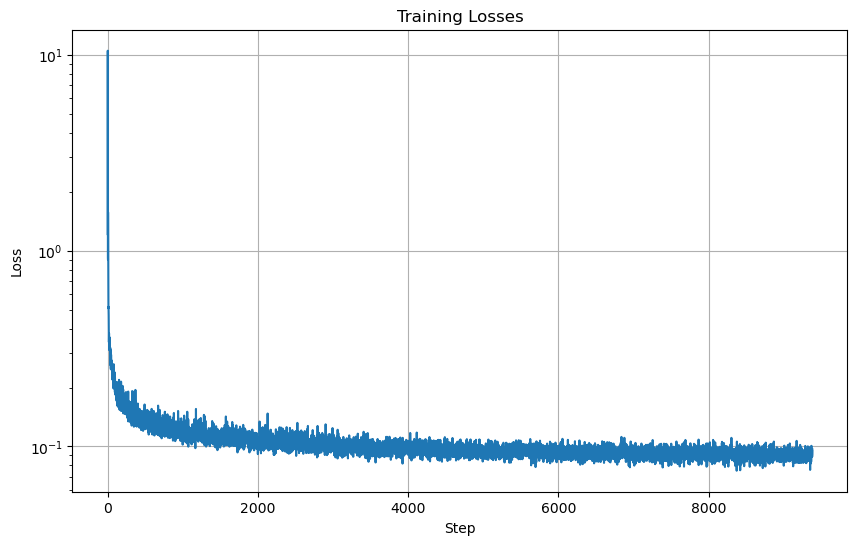

In [ ]:
plot_loss_curve(time_conditional_losses, logscale=True)

## 2.3 Sampling from the UNet

In [ ]:
import random 
def reset_random():
    seed = random.randint(0, 2**32 - 1)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def sample_at_seed(model, seed, img_wh=(28,28), show_img=True): 
    x_t = model.sample(img_wh, seed)
    if show_img:
        media.show_image(media_image(x_t[0]).cpu())
    return x_t

# print in rows of 10 
def sample_at_random_seeds(model, img_wh=(28,28), n_rows=4, print_seed=False): 
    for i in range(n_rows):
        reset_random()  # reset random seed
        row_imgs = []
        for j in range(10):
            seed = random.randint(0, 2**32 - 1)
            if print_seed: print(seed)
            x_t = sample_at_seed(model, seed, img_wh, show_img=False)
            row_imgs.append(media_image(x_t[0]).cpu())        
        media.show_images(row_imgs)

### DELIVERABLE: Sampling results for the time-conditioned UNet for 5 and 10 epochs. 

In [ ]:
sample_at_random_seeds(time_conditional_unet_epoch10, img_wh=(28,28), n_rows=4, print_seed=False)

,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


In [ ]:
sample_at_random_seeds(time_conditional_unet_epoch5, img_wh=(28,28), n_rows=4, print_seed=False)

,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


# Part 2 with Class Conditioning

## 2.4 Adding Class Conditioning to UNet

### 2.4.0 Implementing Simple and Composed Ops

In [ ]:
class Conv(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
       self.bn = nn.BatchNorm2d(out_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class DownConv(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
       self.bn = nn.BatchNorm2d(out_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class UpConv(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
       self.bn = nn.BatchNorm2d(out_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class Flatten(nn.Module):
   def __init__(self):
       super().__init__()
       self.pool = nn.AvgPool2d(7)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.pool(x))

class Unflatten(nn.Module):
   def __init__(self, in_channels: int):
       super().__init__()
       self.conv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0)
       self.bn = nn.BatchNorm2d(in_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class ConvBlock(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv1 = Conv(in_channels, out_channels)
       self.conv2 = Conv(out_channels, out_channels)

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.conv2(self.conv1(x))

class DownBlock(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv_block = ConvBlock(in_channels, out_channels)
       self.down = DownConv(out_channels, out_channels)

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.down(self.conv_block(x))

class UpBlock(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv_block = ConvBlock(in_channels, out_channels)
       self.up = UpConv(out_channels, out_channels)

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.up(self.conv_block(x))

In [ ]:
# fully connected block, which injects time conditioning signal
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear2(self.gelu(self.linear(x.to(device))))

In [ ]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_hiddens = num_hiddens

        # operational layers
        self.opr1 = ConvBlock(self.in_channels, self.num_hiddens)
        self.opr2 = DownBlock(self.num_hiddens, self.num_hiddens)
        self.opr3 = DownBlock(self.num_hiddens, self.num_hiddens * 2)
        self.opr4 = Flatten()
        self.opr5 = Unflatten(self.num_hiddens * 2)
        self.opr6 = UpBlock(self.num_hiddens * 4, self.num_hiddens)
        self.opr7 = UpBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr8 = ConvBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr9 = nn.Conv2d(self.num_hiddens, self.in_channels, kernel_size=3, stride=1, padding=1)

        self.fc1_t = FCBlock(1, self.num_hiddens * 2)
        self.fc2_t = FCBlock(1, self.num_hiddens)
        self.fc1_c = FCBlock(self.num_classes, self.num_hiddens * 2)
        self.fc2_c = FCBlock(self.num_classes, self.num_hiddens)
        
    # make t in the right shape (N, 2D, 1, 1)
    # dimensions are tricky here: [N] -> [N, 1] --fc--> [N, 2D] --> [N, 2D, 1, 1] --> [N, 2D, 7, 7]
    # or the second one to [N,D,14,14]
    def apply_fc_block(self, obj, fc_block):
        if (len(obj.size())) == 1: obj = obj.unsqueeze(-1) # [N] -> [N, 1]
        obj = fc_block(obj) # [N,1] -> [N,2D]
                            # otherwise [N, 10] -> [N, 2D]      
        obj = obj.unsqueeze(-1).unsqueeze(-1) # [N, 2D] -> [N, 2D, 1, 1]
        return obj
    
    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
        c: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,num_classes) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        # apply masking if needed 
        t = t.float().to(t.device)
        c = c.float().to(t.device)
            
        # Encoder
        x1 = self.opr1(x)
        x2 = self.opr2(x1)
        x3 = self.opr3(x2)
        x4 = self.opr4(x3)

        # Decoder
        x_ = self.opr5(x4)
        t1 = self.apply_fc_block(t, self.fc1_t)
        c1 = self.apply_fc_block(c, self.fc1_c)
        x5 = c1 * x_ + t1

        x_ = self.opr6(torch.cat([x3, x5], dim=1))
        t2 = self.apply_fc_block(t, self.fc2_t)
        c2 = self.apply_fc_block(c, self.fc2_c)
        x6 = c2 * x_ + t2

        x7 = self.opr7(torch.cat([x2, x6], dim=1))
        x8 = self.opr8(torch.cat([x1, x7], dim=1))
        x9 = self.opr9(x8)
        return x9

### 2.4.1. Flow Matching Model

In [ ]:
def get_dropout_condition(p_uncond):
    choices = [True, False]
    return random.choices(choices, weights=[p_uncond, 1 - p_uncond])[0]

In [ ]:
def fm_forward(
    unet: ClassConditionalUNet,
    x_1: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 3

    Args:
        unet: ClassConditionalUNet
        x_1: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) loss.
    """
    unet.train()
    
    # dropout c if needed
    c = c if get_dropout_condition(p_uncond) else torch.zeros_like(c)
    
    # we sample a random t because we don't want the model to overfit based on sequential patterns, but also want it to learn the relationship between t and the noise prediction
    t = torch.randint(0, num_ts, (x_1.shape[0],))
    t_normalized = t / num_ts  # normalize t to [0, 1]
    
    # get x_t
    x_0 = torch.randn_like(x_1)  # random noise
    x_t = lerp(x_0, x_1, t_normalized)  # linear interpolation between x_0 and x_1
    flow = x_1 - x_0
    
    # predict flow via unet 
    predicted_flow = unet(x_t, t_normalized, c)
    
    # calculate loss
    loss = torch.nn.functional.mse_loss(predicted_flow, flow)  
    return loss


In [ ]:
@torch.inference_mode()
def fm_sample(
    unet: ClassConditionalUNet,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 4

    Args:
        unet: ClassConditionalUNet
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    torch.manual_seed(seed)
    # make c into a one hot vector if it is only dimension 
    if c.size() == torch.Size([1]):
        a = torch.zeros(unet.num_classes)
        a[c[0].long()] = 1 
        c = a.unsqueeze(0)
    x_t = torch.randn(1, 1, img_wh[0], img_wh[1]).to(device)
    for t in np.linspace(0, 1, num_ts, endpoint=False): 
        t_normalized = torch.Tensor([t]) 
        zeros = torch.zeros_like(c)
        predicted_unconditional_flow = unet(x_t, t_normalized, zeros)
        predicted_conditional_flow = unet(x_t, t_normalized, c)
        predicted_flow = predicted_unconditional_flow + guidance_scale * (predicted_conditional_flow - predicted_unconditional_flow)
        
        # calculate x_t
        x_t = x_t + (1.0/num_ts) * predicted_flow
    return x_t

In [ ]:
class FlowMatching(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) loss.
        """
        return fm_forward(
            self.unet, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return fm_sample(
            self.unet, c, img_wh, self.num_ts, guidance_scale, seed
        )

### TRAINING

In [ ]:
def train_flow_matching(training_set_non_loaded=None, num_epochs=20):
    # shuffle training set and create data loader
    batch_size = 64
    training_set = torch.utils.data.DataLoader(training_set_non_loaded, batch_size=batch_size, shuffle=True)

    # model and hyperparameters
    print("device: ", device)
    num_hiddens = 64
    learning_rate = 1e-2
    unet = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=num_hiddens).to(device)
    model = FlowMatching(unet).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, pow(0.1, 1.0 / num_epochs))
    model_epoch5, model_epoch10 = None, None

    # training loop
    losses = []
    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        for (clean_images, digits) in training_set:
            # make c into one-hot vector with probability p_uncond set to 0
            num_items = clean_images.shape[0]
            num_classes = 10
            one_hot = torch.zeros((num_items, num_classes)).to(device)
            one_hot[torch.arange(one_hot.size(0)).to(device), digits.long()] = 1
            c = one_hot

            # forward pass and compute loss -- predict the noise
            optimizer.zero_grad()
            clean_images = clean_images.to(device)
            predicted_loss = model(clean_images, c)
            # backward pass and update weights
            predicted_loss.backward()
            optimizer.step()
            losses.append(predicted_loss.item())
        if epoch == 5:
            model_epoch5 = copy.deepcopy(model)
        if epoch == 10:
            model_epoch10 = copy.deepcopy(model)

        scheduler.step()  # adjust learning rate after each epoch
    return model, losses, model_epoch5, model_epoch10

In [ ]:
class_conditional_unet, class_conditional_losses, class_conditional_unet_epoch5, class_conditional_unet_epoch10 = train_flow_matching(mnist_train, num_epochs=10)

device:  mps


100%|██████████| 10/10 [16:25<00:00, 98.59s/it]


### DELIVERABLE: A training loss curve plot for the class-conditioned UNet over the whole training process (figure 11)

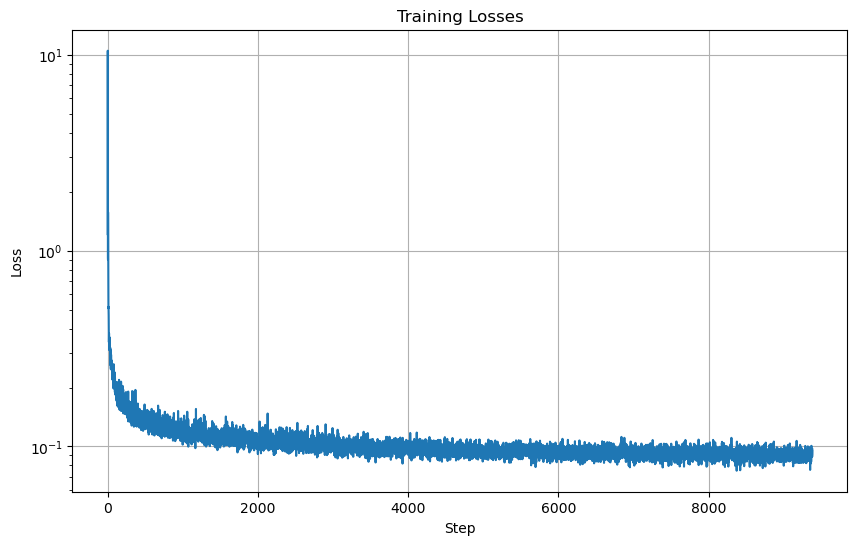

In [ ]:
plot_loss_curve(time_conditional_losses, logscale=True)

## 2.5 Sampling from the Class Conditional UNet

In [ ]:
def reset_random():
    seed = random.randint(0, 2**32 - 1)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
def sample_at_seed(model, seed, img_wh=(28,28), show_img=True, sampling_number=None): 
    x_t = model.sample(torch.Tensor([sampling_number]), img_wh, seed)
    if show_img:
        media.show_image(media_image(x_t[0]).cpu())
    return x_t

# print in rows of 10 
def sample_at_random_seeds(model, img_wh=(28,28), n_rows=4, print_seed=False): 
    for i in range(n_rows):
        reset_random()  # reset random seed
        seed = random.randint(1,15)
        # just use manual seed like 3,4,5,6,7 
        # seed = i + 3 
        if print_seed: print(seed)
        row_imgs = []
        for j in range(10):
            sampling_number = j 
            x_t = sample_at_seed(model, seed, img_wh, show_img=False, sampling_number=sampling_number)
            row_imgs.append(media_image(x_t[0]).cpu())
        media.show_images(row_imgs)

### DELIVERABLE: Sampling results for the class-conditioned UNet for 5 and 10 epochs. Class-conditioning lets us converge faster, hence why we only train for 10 epochs. 

In [ ]:
sample_at_random_seeds(class_conditional_unet_epoch5, img_wh=(28,28), n_rows=4, print_seed=False)

,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


In [ ]:
sample_at_random_seeds(class_conditional_unet_epoch10, img_wh=(28,28), n_rows=4, print_seed=False)

,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,
